In [1]:
#reload the modules before running the program
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
from scipy import signal
from scipy.fft import fftshift
from scipy.fft import fft, fftfreq

import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import os
import math
import cv2

In [2]:
from datasets import RFData, CameraData, SignalDataset, FuseDatasets
import metrics
import utils
import utils_2 as p_lib

In [4]:
np.random.seed(0)
torch.manual_seed(0)
data_path = r"D:\osa_new_proc_rev"
# trial_folders = ["v_12_5", "v_13_5", "v_13_10"]
trial_folders = os.listdir(data_path)

# train_idxs = np.linspace(0, 49, 50, dtype=int)
train_folders = trial_folders#[trial_folders[i] for i in train_idxs]
# test_folders = [trial_folders[i] for i in range(len(trial_folders)) if i not in train_idxs]


thermal_file_name = "Thermal_Camera"
num_samps_oversample = 20 # None # per experiment, number of samples to generate
data_length = 9000
fs = 30
out_len = 1800 # sample length generated
thermal_ext = ".npy"

dataset_thermal_train = CameraData(data_path, train_folders, thermal_file_name, num_samps_oversample, fs, data_length, out_len, thermal_ext)
# dataset_thermal_test = CameraData(data_path, test_folders, thermal_file_name, num_samps_oversample, fs, data_length, out_len, thermal_ext)

In [5]:
fs = 30
out_len = 1800
t_arr = np.linspace(0, (out_len-1)/fs, out_len)

In [6]:
# NUKS_idx = np.load(r"E:\OSA_project\Emir_Clean\saved_idx\NUKS_idx.npy")
# mode_lock_idx = np.load(r"E:\OSA_project\Emir_Clean\saved_idx\mode_lock_idx.npy")
# movement_idx = np.load(r"E:\OSA_project\Emir_Clean\saved_idx\movement_idx.npy")
path =r"F:\OSA_local_version\OSA_project\Emir_Clean\saved_data"
X = np.load(os.path.join(path, r"thermal_arrv5.npy"))
y = np.load(os.path.join(path, r"gt_arrv5.npy"))


In [7]:
PATH = r"F:\OSA_local_version\OSA_project\Emir_Clean\saved_data"
NUKS_idx = np.load(os.path.join(PATH, "NUKS_idxv5.npy"))
mode_lock_idx = np.load(os.path.join(PATH, "mode_lock_idxv5.npy"))
movement_idx = np.load(os.path.join(PATH, "movement_idxv5.npy"))
vid_movement_idx = np.load(os.path.join(PATH, "vid_movement_idxv5.npy"))

In [8]:
def linear_func(m, b, n, length_mode=False):
    if(length_mode == True):
        def func(x):
            return(max(int(m*(x**n) + b), 1))
        return(func)
    else:
        def func(x):
            return(max(int(m*(len(x)**n) + b), 1))
        return(func)

In [9]:
path= r"F:\OSA_local_version\OSA_project\Emir_Clean\patient_folder"
patient_idxs = np.concatenate((np.load(os.path.join(path, "patient_idxs_12.npy")), np.load(os.path.join(path, "patient_idxs_13.npy")), np.load(os.path.join(path, "patient_idxs_20.npy")), np.load(os.path.join(path, "patient_idxs_29.npy")), np.load(os.path.join(path, "patient_idxs_30.npy")), np.load(os.path.join(path, "patient_idxs_36.npy")), np.load(os.path.join(path, "patient_idxs_40.npy"))))

In [10]:
count = 0
for idx in tqdm(patient_idxs):
    if((idx not in NUKS_idx) and (idx not in mode_lock_idx)): #and (idx not in patient_39) and (idx not in patient_37)):
      count = count + 1
    
print((count*1800/30)/3600)

100%|██████████| 2960/2960 [00:00<00:00, 80212.04it/s]

41.93333333333333


In [11]:
def intraclass_correlation(x, y):
    assert(len(x) != 0)
    mu_x = 0
    for i in range(len(x)):
        mu_x = mu_x + (x[i] + y[i])
    mu_x = mu_x/(2*len(x))

    s_sq = 0
    for i in range(len(x)):
        s_sq  = s_sq  + (x[i] - mu_x)**2 +  (y[i] - mu_x)**2
    s_sq = s_sq/(2*len(x))

    r = 0
    assert(s_sq != 0)
    for i in range(len(x)):
        r = r + (x[i] - mu_x)*(y[i] - mu_x)
    r = r/(len(x)*s_sq)
    return(r)

In [12]:
import utils_2 as p_lib3

  0%|          | 0/1 [00:00<?, ?it/s]

gt diff 0.10333333333333333
pred mean:  0.10333333333333333
OSA mean:  0.0 CSA mean:  0.0
idx:  61


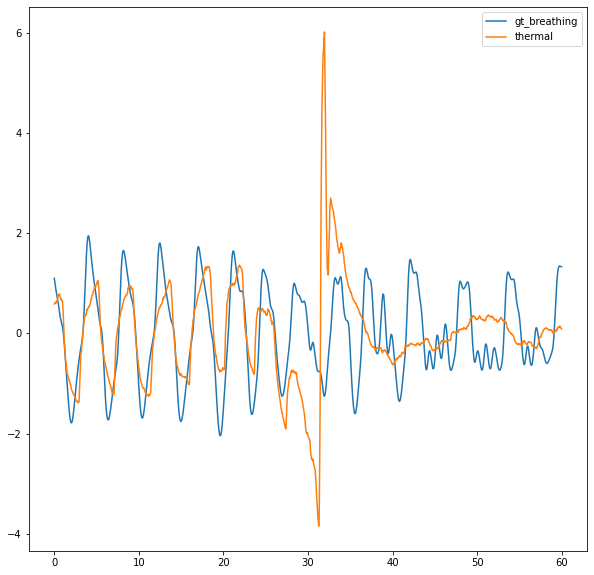

lmin:  211 lmax:  212 

212 211


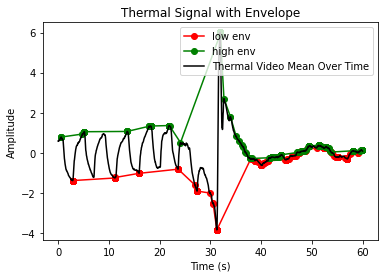

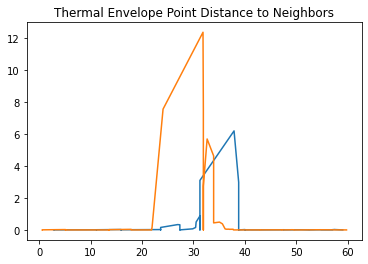

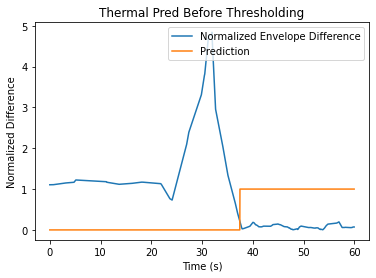

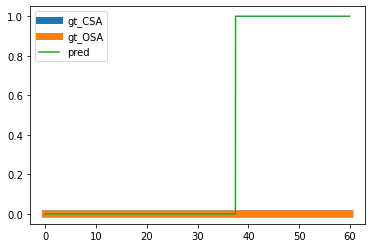

###########################################################################


100%|██████████| 1/1 [00:10<00:00, 10.74s/it]

Mean Absolute Error:  0.013939939939939939
interclass_correlation:  0.5573122529644522
0.2878787878787879 (0.2, 'mean', 1.4954, 0.5, 0.8507462686567164, 0.4351145038167939, 0.9646464646464646, array([[  57,   10],
       [  74, 2235]]))


In [18]:
# 0.33333333333333337 mode:  mean dmin:  5 dmax:  8
dmax_arr = []
dmin_arr = []
th_arr = []
full_arr = []
prod_arr = []
ths_arr = [0.2]#np.linspace(0.05, 0.4, 10)
window_max = 27#np.linspace(2,40, 10, dtype=int)
window_min = 27#np.linspace(2,40, 10, dtype=int)
mode = 'mean'
wrong_idxs = []

m_arr = [1.4954]#np.append(np.append(np.linspace(1/20, 1, 20), np.linspace(2, 20, 19)), 1.4954545454545456)
n_arr = [0.5]#np.linspace(0.1, 1, 10)
 # 1.4954545454545456, 0.5
for th in tqdm(ths_arr):
    for n in n_arr:
        for m in m_arr:
            dmin_func = linear_func(m, 0, n, length_mode=False)
            gt_arr = []
            pred_arr = []
            MAE_err = 0
            for idx in tqdm(patient_idxs):
                    if((idx not in NUKS_idx) and (idx not in mode_lock_idx) and (idx not in movement_idx) and (idx not in vid_movement_idx)):
                        pred = utils.predict(X[idx], dmin=window_min, dmax=window_max, dmin_func=dmin_func, dmax_func=dmin_func, th=th, mode=mode, plot=False)
                        # print('idx: ', idx)

                        gt_OSA = y[idx][1]
                        gt_CSA = y[idx][2]

                        if(np.mean(pred) > 0.08666666666666667):
                            pred_arr.append(1)
                        else:
                            pred_arr.append(0)

                        if((np.mean(gt_OSA) > 0.05) or (np.mean(gt_CSA) > 0.05)):# or (np.mean(gt_hp) > 0.1)):
                            gt_arr.append(1)
                        else:
                            gt_arr.append(0)
                        MAE_err = MAE_err + np.mean(abs(pred  - np.logical_or(gt_CSA, gt_OSA)))

                    if((idx not in NUKS_idx) and (idx not in mode_lock_idx) and (idx  in movement_idx) and (idx in vid_movement_idx)): # from data processing local .ipynb
                        thermal = X[idx]
                        gt_breathing = y[idx][0]
                        gt_OSA = y[idx][1]
                        gt_CSA = y[idx][2]
                        pred = p_lib3.depth2_apnea_predictor(signal=thermal, time_arr=t_arr, th=0.23, dmin=22, dmax=32, dmax_func=None, dmin_func=None, mode=mode, plot=False, prints=False, gt_signal=gt_breathing, include_edges=True, motion_th=4.5)
                        _ , pred = p_lib3.get_apnea_count(pred, center_th=300, plot=False, lims=None)

                        if(np.mean(pred) > 0.08666666666666667):
                            pred_arr.append(1)
                        else:
                            pred_arr.append(0)

                        if((np.mean(gt_OSA) > 0.05) or (np.mean(gt_CSA) > 0.05)):# or (np.mean(gt_hp) > 0.1)):
                            gt_arr.append(1)
                        else:
                            gt_arr.append(0)
                        MAE_err = MAE_err + np.mean(abs(pred  - np.logical_or(gt_CSA, gt_OSA)))
                    
                    if((gt_arr[-1] != pred_arr[-1]) and (idx == 61)):
                        wrong_idxs.append(idx)
                        print('gt diff', min(np.mean(pred - gt_OSA), np.mean(pred - gt_CSA)))
                        print('pred mean: ', np.mean(pred))
                        print('OSA mean: ', np.mean(gt_OSA), 'CSA mean: ', np.mean(gt_CSA))
                        plt.figure(figsize=(10,10))
                        print('idx: ', idx)
                        plt.plot(t_arr, y[idx][0], label='gt_breathing')
                        plt.plot(t_arr, X[idx], label='thermal')
                        plt.legend()
                        plt.show()
                        pred = utils.predict(X[idx], dmin=window_min, dmax=window_max, dmin_func=dmin_func, dmax_func=dmin_func, th=th, mode=mode, plot=True, prints=True)
                        plt.plot(t_arr, gt_CSA, linewidth=7.0, label='gt_CSA')
                        plt.plot(t_arr,gt_OSA, linewidth=7.0, label='gt_OSA')
                        plt.plot(t_arr, pred, label='pred')
                        plt.legend()
                        plt.show()
                        print(r"###########################################################################")
                        
            print('Mean Absolute Error: ', MAE_err/len(patient_idxs))
            print('interclass_correlation: ', intraclass_correlation(pred_arr, gt_arr))
            precision, recall, accuracy, confusion_matrix = utils.get_stats(np.array(pred_arr), np.array(gt_arr))                    
            prod_arr.append(precision*recall / (precision + recall))
            if(dmin_func is not None):
                full_arr.append((th, mode, m, n, recall, precision, accuracy, confusion_matrix))
            else:
                full_arr.append((th, mode, window_min, window_max, recall, precision, accuracy, confusion_matrix))
            dmax_arr.append(window_max)
            dmin_arr.append(window_min)
            th_arr.append(th)
if(len(prod_arr) > 1):
    for i in range(len(prod_arr)):
        if(math.isnan(prod_arr[i])):
            prod_arr[i] = 0
    
    best_idxs = np.argsort(prod_arr)[::-1]
    print((prod_arr[best_idxs[0]], full_arr[best_idxs[0]]))
else:
    print(prod_arr[0], full_arr[0])

In [17]:
index_list = [wrong_idxs[0]]
dataset_thermal_train.get_vid = True
for index in index_list:
    path_vid = r"F:\OSA_local_version\OSA_project"
    print('index: ', index)
    image_arr = dataset_thermal_train.__getitem__(index)
    # thumbnail = f"E:\OSA_project\Kai_data\{index}.png"
    # plt.imshow(image_arr[0])
    # plt.savefig(thumbnail) 
    norm_im = utils.normalize(image_arr)
    # Output video file name
    output_video = os.path.join(path_vid, f"{index}.mp4")
    height, width, = 64, 64
    fs = 30

    # Create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MP42')
    video = cv2.VideoWriter(output_video, fourcc, fs, (width, height))

    # Iterate over the image files and write each frame to the video
    for i in range(len(norm_im)):
        img = cv2.applyColorMap(norm_im[i], cv2.COLORMAP_JET)
        video.write(img)

    # Release the VideoWriter object
    video.release()

index:  61


In [152]:
import utils_2 as p_lib3

In [154]:
# 0.33333333333333337 mode:  mean dmin:  5 dmax:  8
dmax_arr = []
dmin_arr = []
th_arr = []
full_arr = []
prod_arr = []
ths_arr = [0.2]#np.linspace(0.05, 0.4, 10)
window_max = 27#np.linspace(2,40, 10, dtype=int)
window_min = 27#np.linspace(2,40, 10, dtype=int)
mode = 'mean'

m_arr = np.append(np.append(np.linspace(1/20, 1, 5), np.linspace(2, 10, 14)), 1.4954545454545456)
n_arr = np.linspace(0.1, 1, 10)
 # 1.4954545454545456, 0.5
for th in tqdm(ths_arr):
    for n in n_arr:
        for m in m_arr:
            dmin_fun = linear_func(m, 0, n, length_mode=False)
            dmin = 32
            dmax = 32
            gt_arr = []
            pred_arr = []
            MAE_err = 0
            for idx in (patient_idxs):
                    if((idx not in NUKS_idx) and (idx not in mode_lock_idx) and (idx  in movement_idx) and (idx in vid_movement_idx)): #and (idx not in patient_39) and (idx not in patient_37)):
                        thermal = X[idx]
                        gt_breathing = y[idx][0]
                        gt_OSA = y[idx][1]
                        gt_CSA = y[idx][2]
                        # pred = p_lib3.depth2_apnea_predictor(signal=thermal, time_arr=t_arr, th=th, dmin=dmin, dmax=dmax, dmax_func=None, dmin_func=None, mode=mode, plot=False, prints=False, gt_signal=gt_breathing, include_edges=True, motion_th=4.5)
                        pred = p_lib3.depth2_apnea_predictor(signal=thermal, time_arr=t_arr, th=th, dmin=dmin, dmax=dmax, dmax_func=dmin_fun, dmin_func=dmin_fun, mode=mode, plot=False, prints=False, gt_signal=gt_breathing, include_edges=True, motion_th=4.5)
                        _ , pred = p_lib3.get_apnea_count(pred, center_th=300, plot=False, lims=None)

                        
                        # plt.figure(figsize=(10,10))
                        # print('idx: ', idx)
                        # print('pred mean: ', np.mean(pred))

                        # plt.plot(t_arr, y[idx][0], label='gt_breathing')
                        # plt.plot(t_arr, X[idx], label='thermal')
                        # plt.legend()
                        # plt.show()
                        # plt.plot(t_arr, gt_CSA, linewidth=7.0, label='gt_CSA')
                        # plt.plot(t_arr, gt_OSA, linewidth=7.0, label='gt_OSA')
                        # plt.plot(t_arr, pred, label='pred')
                        # plt.legend()
                        # plt.show()
                        # pred = utils.predict(X[idx], dmin=window_min, dmax=window_max, dmin_func=dmin_func, dmax_func=dmin_func, th=th, mode=mode, plot=False)
                        # print('idx: ', idx)
                        # plt.plot(t_arr, pred, label='pred before')
                        # plt.plot(t_arr, remove_excess(pred), label='pred after')
                        # plt.plot(t_arr, gt_CSA, linewidth=7.0, label='gt_CSA')
                        # plt.plot(t_arr,gt_OSA, linewidth=7.0, label='gt_OSA')
                        # plt.legend()
                        # plt.show()

                        # gt_OSA = remove_excess(gt_OSA)
                        # gt_CSA = remove_excess(gt_CSA)
                        # gt_hp = gt_hypopnea[idx]

                        if(np.mean(pred) > 0.08666666666666667):
                            pred_arr.append(1)
                        else:
                            pred_arr.append(0)

                        if((np.mean(gt_OSA) > 0.05) or (np.mean(gt_CSA) > 0.05)):# or (np.mean(gt_hp) > 0.1)):
                            gt_arr.append(1)
                        else:
                            gt_arr.append(0)
                    
                        # if((gt_arr[-1] != pred_arr[-1])):
                        #     p_lib3.depth2_apnea_predictor(signal=thermal, time_arr=t_arr, th=th, dmin=dmin, dmax=dmax, dmax_func=dmin_fun, dmin_func=dmin_fun, mode=mode, plot=True, prints=True, gt_signal=gt_breathing, include_edges=True, motion_th=4.5)

                        #     print('gt diff', gt_arr[-1], pred_arr[-1])
                        #     print('pred mean: ', np.mean(pred))
                        #     print('OSA mean: ', np.mean(gt_OSA), 'CSA mean: ', np.mean(gt_CSA))
                        #     plt.figure(figsize=(10,10))
                        #     print('idx: ', idx)
                        #     plt.plot(t_arr, y[idx][0], label='gt_breathing')
                        #     plt.plot(t_arr, X[idx], label='thermal')
                        #     plt.legend()
                        #     plt.show()
                        #     plt.plot(t_arr, gt_CSA, linewidth=7.0, label='gt_CSA')
                        #     plt.plot(t_arr,gt_OSA, linewidth=7.0, label='gt_OSA')
                        #     plt.plot(t_arr, pred, label='pred')
                        #     plt.title('FINAL PRED PLOT')
                        #     plt.legend()
                        #     plt.show()
                        #     print(r"###########################################################################")
                        MAE_err = MAE_err + np.mean(abs(pred  - np.logical_or(gt_CSA, gt_OSA)))
            print('Mean Absolute Error: ', MAE_err/len(patient_idxs))
            # print('interclass_correlation: ', intraclass_correlation(pred_arr, gt_arr))
            precision, recall, accuracy, confusion_matrix = utils.get_stats(np.array(pred_arr), np.array(gt_arr))                    
            prod_arr.append(precision*recall / (precision + recall))
            if(dmin_func is not None):
                full_arr.append((th, mode, m, n, recall, precision, accuracy, confusion_matrix))
            else:
                full_arr.append((th, mode, window_min, window_max, recall, precision, accuracy, confusion_matrix))
            dmax_arr.append(window_max)
            dmin_arr.append(window_min)
            th_arr.append(th)
if(len(prod_arr) > 1):
    for i in range(len(prod_arr)):
        if(math.isnan(prod_arr[i])):
            prod_arr[i] = 0
    
    best_idxs = np.argsort(prod_arr)[::-1]
    print((prod_arr[best_idxs[0]], full_arr[best_idxs[0]]))
else:
    print(prod_arr[0], full_arr[0])

  0%|          | 0/1 [00:00<?, ?it/s]

Mean Absolute Error:  0.08433089339339342
Mean Absolute Error:  0.08433089339339342
Mean Absolute Error:  0.08433089339339342
Mean Absolute Error:  0.08433089339339342
Mean Absolute Error:  0.08433089339339342
Mean Absolute Error:  0.08062368618618612
Mean Absolute Error:  0.07894519519519522
Mean Absolute Error:  0.07509403153153156
Mean Absolute Error:  0.06667905405405408
Mean Absolute Error:  0.06005499249249251
Mean Absolute Error:  0.04802759009009012
Mean Absolute Error:  0.03939846096096097
Mean Absolute Error:  0.028967905405405402
Mean Absolute Error:  0.025871433933933936
Mean Absolute Error:  0.019790915915915905
Mean Absolute Error:  0.016960585585585584
Mean Absolute Error:  0.014036036036036034
Mean Absolute Error:  0.012850225225225225
Mean Absolute Error:  0.01135078828828829
Mean Absolute Error:  0.08210529279279279
Mean Absolute Error:  0.08433089339339342
Mean Absolute Error:  0.08433089339339342
Mean Absolute Error:  0.08433089339339342
Mean Absolute Error:  0.0830

C:\Users\111\AppData\Local\Temp/ipykernel_23944/125079415.py:94: RuntimeWarning: invalid value encountered in double_scalars
  prod_arr.append(precision*recall / (precision + recall))


Mean Absolute Error:  0.001507507507507508
Mean Absolute Error:  0.013332770270270276
Mean Absolute Error:  0.08433089339339342
Mean Absolute Error:  0.07883783783783789
Mean Absolute Error:  0.0471510885885886
Mean Absolute Error:  0.023363551051051052
Mean Absolute Error:  0.012326764264264264
Mean Absolute Error:  0.00414451951951952
Mean Absolute Error:  0.003101726726726726
Mean Absolute Error:  0.002153153153153154
Mean Absolute Error:  0.001886073573573574
Mean Absolute Error:  0.0018104354354354358
Mean Absolute Error:  0.0015805180180180187
Mean Absolute Error:  0.0015763888888888893
Mean Absolute Error:  0.001507507507507508
Mean Absolute Error:  0.0014324324324324327
Mean Absolute Error:  0.0014324324324324327
Mean Absolute Error:  0.0013201951951951952
Mean Absolute Error:  0.0013201951951951952
Mean Absolute Error:  0.0013201951951951952
Mean Absolute Error:  0.0013201951951951952
Mean Absolute Error:  0.0063316441441441445
Mean Absolute Error:  0.08356569069069074
Mean Ab

100%|██████████| 1/1 [21:01<00:00, 1261.82s/it]

Mean Absolute Error:  0.0013201951951951952
(0.18446601941747573, (0.2, 'mean', 8.153846153846153, 0.2, 0.7307692307692307, 0.24675324675324675, 0.7670250896057348, array([[ 19,   7],
       [ 58, 195]])))


In [156]:
if(len(prod_arr) > 1):
    for i in range(len(prod_arr)):
        if(math.isnan(prod_arr[i])):
            prod_arr[i] = 0
    
    best_idxs = np.argsort(prod_arr)[::-1]
    print((prod_arr[best_idxs[0]], full_arr[best_idxs[0]]))
else:
    print(prod_arr[0], full_arr[0])

(0.18446601941747573, (0.2, 'mean', 8.153846153846153, 0.2, 0.7307692307692307, 0.24675324675324675, 0.7670250896057348, array([[ 19,   7],
       [ 58, 195]])))


In [ ]:
# (0.17857142857142855, (0.2, 'mean', 8.153846153846153, 0.2, 0.7692307692307693, 0.23255813953488372, 0.7419354838709677, array([[ 20,   6],
#        [ 66, 187]])))

In [109]:
import numpy as np
import matplotlib.pyplot as plt

def apnea_predictor(signal, time_arr, th=0.4, dmin=25, dmax=25, dmax_func=None, dmin_func=None, mode='mean', plot=False, prints=False, gt_signal=None, include_edges=True, motion_th=4.5, split=False):
    if(split == False):
        return(depth2_apnea_predictor(signal, time_arr, th=th, dmin=dmin, dmax=dmax, dmax_func=dmax_func, dmin_func=dmin_func, mode=mode, plot=plot, prints=prints, gt_signal=gt_signal, include_edges=include_edges, motion_th=motion_th))
    else:
        pred = np.zeros(len(signal))
        for i in range(0, 5):
            if(prints == True):
                print(f"{i}th iteration")
            new_signal = signal[i*1800:(i+1)*1800]
            new_time_arr = time_arr[i*1800:(i+1)*1800]
            new_gt_signal = gt_signal[i*1800:(i+1)*1800]
            pred[i*1800:(i+1)*1800] = depth2_apnea_predictor(new_signal, new_time_arr, th=th, dmin=dmin, dmax=dmax, dmax_func=dmax_func, dmin_func=dmin_func, mode=mode, plot=plot, prints=prints, gt_signal=new_gt_signal, include_edges=include_edges, motion_th=motion_th)
        return(pred)

def hl_envelopes_idx(signal, dmin=1, dmax=1, dmax_func=None, dmin_func=None, step_size=1, prints=False):
    """
    Input :
    signal: 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax: int, optional, size of chunks, use this if the signal has a lot of minima/maxima
    dmin_func, dmax_func: function, optional, used to calculate signal dependent chunk size
    step_size: int, optional, stride size for windowing the chunks
    Output :
    lmin,lmax : high/low envelope idx of input signal
    """
    lmin = (np.diff(np.sign(np.diff(signal))) > 0).nonzero()[0] + 1 
    lmax = (np.diff(np.sign(np.diff(signal))) < 0).nonzero()[0] + 1

    # if((len(lmax) > 500) or (len(lmin) > 500)):
    #     dmin = int(len(lmin)/10)
    #     dmax = int(len(lmax)/10)
    dmin_num = dmin
    dmax_num = dmax
    if(dmax_func is not None):
        dmax_num = dmax_func(lmax)

    if(dmin_func is not None):
        # print('len(lmin): ', len(lmin), '\n')
        dmin_num = dmin_func(lmin)
    
    if(prints == True):
        print('len(lmax): ', len(lmax), '\n')
        print('len(lmin): ', len(lmin), '\n')
        print('step size: ', step_size, '\n')
        print('dmin: ', dmin_num)
        print('dmax: ', dmax_num)
        
    if(dmin_num != 1):
        lmin = lmin[[max(i-dmin_num//2,0)+np.argmin(signal[lmin[max(i-dmin_num//2,0):min(i+dmin_num//2,len(lmin))]]) for i in range(0,len(lmin),step_size)]]
    
    if(dmax_num != 1):
        lmax = lmax[[max(i-dmax_num//2,0)+np.argmax(signal[lmax[max(i-dmax_num//2,0):min(i+dmax_num//2,len(lmax))]]) for i in range(0,len(lmax),step_size)]]
    
    return(lmin,lmax)

def predict(signal, time_arr, th=0.4, dmin=25, dmax=25, dists_min=None, dists_max=None, dmax_func=None, dmin_func=None, mode='mean', percentage=25, plot=False, prints=False):
    """
    Input: 
    signal: 1d-array, data signal
    time_arr: 1d-array, optional, array corresponding time stamps for plotting signal, only used if plot is true
    th: float, threshold value for apnea prediction
    dmin, dmax: int, optional, size of chunks, use this if the signal has a lot of minima/maxima
    dmin_func, dmax_func: function, optional, used to calculate signal dependent chunk size
    mode: str, mode of normalization
    percentage: float, % percentile normalization if mode is not one of 'mean', 'median', or '90th'
    plot: bool, optional, true if user wants to plot the relevant graphs
    prints: bool, optional, true if user wants to print relevant statments
    Output:
    pred: 1d-array, binary prediction
    """
    lmin, lmax = hl_envelopes_idx(signal=signal, dmin=dmin, dmax=dmax, dmax_func=dmax_func, dmin_func=dmin_func, prints=prints)
    
    if(len(lmin) == 0 or len(lmax) == 0): # signal has no contrast
        return(np.zeros(len(signal)))
        
    max_th = np.interp(time_arr, time_arr[lmax], signal[lmax])
    min_th = np.interp(time_arr, time_arr[lmin], signal[lmin])

    pred = None
    cn = None
    if(mode == 'max'):
        pred = ((max_th - min_th)/max(max_th - min_th) < th).astype(int)
        cn = max(max_th - min_th)
    elif(mode == '90th'):
        pred = ((max_th - min_th)/np.percentile(max_th - min_th, 90) < th).astype(int)
        cn = np.percentile(max_th - min_th, 90)
    elif(mode == 'median'):
        pred = ((max_th - min_th)/np.median(max_th - min_th) < th).astype(int)
        cn = np.median(max_th - min_th)
    elif(mode == 'mean'):
        pred = ((max_th - min_th)/np.mean(max_th - min_th) < th).astype(int)
        cn = np.mean(max_th - min_th)
    else:
        pred = ((max_th - min_th)/np.percentile(max_th - min_th, percentage) < th).astype(int)
        cn = np.percentile(max_th - min_th, percentage)

    if(prints == True):
        print("lmin: ", len(lmin), "lmax: ", len(lmax), '\n')

    if(plot == True):
        
        lx = time_arr[lmin]
        mx = time_arr[lmax]

        min_env = signal[lmin]
        max_env = signal[lmax]

        plt.figure(figsize=(50,10))
        plt.plot(lx, min_env, 'ro-', label='low env')
        plt.plot(mx, max_env, 'go-', label='high env')
        plt.plot(time_arr, signal, color='black', label='Thermal Video Mean Over Time')
        plt.title("Thermal Signal with Envelope")
        plt.ylabel("Amplitude")
        plt.xlabel("Time (s)")
        plt.legend()
        # plt.axis('off')
        plt.show()

        # if((dists_min is not None) and (dists_max is not None)):
        #     if((len(dists_min) == len(lx)) and (len(dists_max) == len(mx))):
        #         plt.figure(figsize=(50,10))
        #         plt.plot(lx, dists_min, label='low')
        #         plt.plot(mx, dists_max, label='high')
        #         plt.title("Thermal Envelope Point Distance to Neighbors")
        #         plt.show()

        plt.figure(figsize=(50,10))
        plt.plot(time_arr, (max_th - min_th)/cn, label='Normalized Envelope Difference')
        plt.plot(time_arr, pred, label='Prediction')
        plt.title("Thermal Pred Before Thresholding")
        plt.xlabel("Time (s)")
        plt.ylabel("Normalized Difference")
        plt.legend()
        plt.show()

    return(pred)

def get_motion_scores(signal, dmin=5, dmax=5, dmax_func=None, dmin_func=None, plot=False, time_arr=None, gt_signal=None, include_edges=True):
    """
    Input :
    signal: 1d-array, data signal for which to assign motion scores
    dmin, dmax: int, optional, size of chunks, use this if the signal has a lot of minima/maxima
    plot: bool, optional, true if user wants to plot the relevant graphs
    time_arr: 1d-array, optional, array corresponding time stamps for plotting signal, only used if plot is true
    gt_signal: 1d-array, optional, ground truth signal, only used if plot is true
    include_edges: bool, optional, include the start and end of signal in the motion score calculation if true
    Output :
    lmin,lmax : high/low envelope idx of input signal
    dists_min, dists_max: motion scores associated with each minima/maxima
    """
    # Note: Time Complexity can be improved by vectorizing this function
    lmin, lmax = hl_envelopes_idx(signal=signal, dmin=dmin, dmax=dmax, dmax_func=dmax_func, dmin_func=dmin_func)

    min_env = signal[lmin]
    max_env = signal[lmax]
    half_len = 4 # N-nearest neighbor parameter

    dists_min = []
    dists_max = []

    if((include_edges == True) and (len(max_env) >  half_len)):
        start_vec = [(max_env[0]-max_env[1+i])**2 for i in range(half_len)]
        start_vec = np.array(start_vec)
        dists_max.append(np.sum(start_vec)/((1 or np.mean(start_vec[np.argsort(start_vec)[::-1]]))*len(start_vec)))
        

   
    for i in range(1, len(max_env)-1):
        vec_start = max(0, i - half_len)
        vec_end = min(len(max_env), i + half_len)
        vec = max_env[vec_start:vec_end]
        vec = np.array(vec)
        center_vec = np.repeat(max_env[i], len(vec))
        dist = np.sum((center_vec - vec)**2)/((1 or np.mean(vec[np.argsort(vec)[::-1]]))*len(vec))
        dists_max.append(dist)

    if((include_edges == True) and (len(max_env) >  half_len) and (len(min_env) >  half_len)):
        end_vec = [(max_env[len(max_env)-1]-max_env[len(max_env)-2-i])**2  for i in range(half_len)]
        end_vec = np.array(end_vec)
        dists_max.append(np.sum(end_vec)/((1 or np.mean(end_vec[np.argsort(end_vec)[::-1]]))*len(end_vec)))

        start_vec = [(min_env[0]-min_env[1+i])**2 for i in range(half_len)]
        start_vec= np.array(start_vec)
        dists_min.append(np.sum(start_vec)/((1 or np.mean(start_vec[np.argsort(start_vec)[::-1]]))*len(start_vec)))

    for i in range(1, len(min_env)-1):
        vec_start = max(0, i - half_len)
        vec_end = min(len(min_env), i + half_len)
        vec = min_env[vec_start:vec_end]
        vec = np.array(vec)
        center_vec = np.repeat(min_env[i], len(vec))
        dist = np.sum((center_vec - vec)**2)/((1 or np.mean(vec[np.argsort(vec)[::-1]]))*len(vec))
        dists_min.append(dist)

    if((include_edges == True) and (len(min_env) >  half_len)):
        end_vec = [(min_env[len(min_env)-1]-min_env[len(min_env)-2-i])**2  for i in range(half_len)]
        end_vec = np.array(end_vec)
        dists_min.append(np.sum(end_vec)/((1 or np.mean(end_vec[np.argsort(end_vec)[::-1]]))*len(end_vec)))

    dists_min = np.array(dists_min)
    dists_max = np.array(dists_max)

    if(plot == True):
        if(len(lmin) == 0 or len(lmax) == 0): # signal has no contrast
            lx = []
            min_env = []

            mx = []
            max_env = []
        else:
            lx = time_arr[lmin]
            min_env = signal[lmin]

            mx = time_arr[lmax]
            max_env = signal[lmax]
        
        
        # dists_min, dists_max = get_motion_scores(max_env, min_env, half_len=2)
        plt.plot(lx, min_env, 'ro-', label='low')
        plt.plot(mx, max_env, 'go-', label='high')
        plt.plot(time_arr, signal, color='black', label='Thermal Signal')
        if(gt_signal is not None):
            plt.plot(time_arr, gt_signal, label='gt_signal')
        plt.title("Thermal Signal with Envelope")
        plt.xlabel("Time (s)")
        plt.legend()
        plt.show()
        if((len(dists_min) == len(lx)) and (len(dists_max) == len(mx))):
            plt.plot(lx, dists_min, label='low')
            plt.plot(mx, dists_max, label='high')
            plt.title("Thermal Envelope Point Distance to Neighbors")
            plt.show()
    return(dists_min, dists_max, lmin, lmax)

def find_movement_peaks(dists_min, dists_max, lmin, lmax, time_arr, amplitude_th, sample_idx_threshold, prints=False, plot=False):
    """
    Input :
    dists_min, dists_max: motion scores associated with each minima/maxima
    lmin,lmax : high/low envelope idx of input signal
    time_arr: 1d-array, array corresponding time stamps
    amplitude_th: float, amplitude threshold to seperate motion peaks that need to be removed
    sample_idx_thershold: float, if multiple motion peaks are within a sample index threshold (divide by fs to convert to time) perform suppression by taking the median peak
    plot: bool, optional, true if user wants to plot the relevant graphs
    Output :
    center_list_max: a list of motion peak locations in units of sample index
    """
    time_arr_min = time_arr[lmin]
    idx_min = []
    x_min = []
    y_min = []

    for i in range(len(dists_min)):
        if(dists_min[i] > amplitude_th):
            idx_min.append(lmin[i])
            x_min.append(time_arr_min[i])
            y_min.append(dists_min[i])
    
    center_list_min = []
    cx_min = []
    i = 0
    while((len(x_min) != 0) and (i < len(y_min))):
        offset = 1
        avg_pos_arr = [(x_min[i], y_min[i], idx_min[i])]
        while(((i + offset) < len(y_min)) and (abs(x_min[i] - x_min[i+offset]) < sample_idx_threshold)):
            avg_pos_arr.append((x_min[i+offset], y_min[i+offset], idx_min[i+offset]))
            offset += 1
        
        centers = []
        cx = []
        for xy in avg_pos_arr:
            x_min.remove(xy[0])
            y_min.remove(xy[1])
            idx_min.remove(xy[2])
            centers.append(xy[2])
            cx.append(xy[0])
        center_list_min.append(np.median(centers)) # can change this to be the mean
        cx_min.append(np.median(cx))

    time_arr_max = time_arr[lmax]
    idx_max = []
    x_max = []
    y_max = []

    for i in range(len(dists_max)):
        if(dists_max[i] > amplitude_th):
            idx_max.append(lmax[i])
            x_max.append(time_arr_max[i])
            y_max.append(dists_max[i])
    
    center_list_max = []
    cx_max = []
    i = 0
    while((len(x_max) != 0) and (i < len(y_max))):
        offset = 1
        avg_pos_arr = [(x_max[i], y_max[i], idx_max[i])]
        while(((i + offset) < len(y_max)) and (abs(x_max[i] - x_max[i+offset]) < sample_idx_threshold)):
            avg_pos_arr.append((x_max[i+offset], y_max[i+offset], idx_max[i+offset]))
            offset += 1
        
        centers = []
        cx = []
        for xy in avg_pos_arr:
            x_max.remove(xy[0])
            y_max.remove(xy[1])
            idx_max.remove(xy[2])
            centers.append(xy[2])
            cx.append(xy[0])
        center_list_max.append(np.median(centers)) # can change this to be the mean
        cx_max.append(np.median(cx))

    if(prints == True):
        print("Center List Max: ", center_list_max, '\n')
        print("Center List Min: ", center_list_min, '\n')

    for i in range(len(center_list_max)):
        t = time_arr[int(center_list_max[i])]
        for j in range(len(center_list_min)):

            if(prints == True):
                print("t: ", t, "time_arr: ", time_arr[int(center_list_min[j])], '\n')
                print(abs(t - time_arr[int(center_list_min[j])]), sample_idx_threshold, '\n')

            if((len(center_list_min) != 0) and (abs(t - time_arr[int(center_list_min[j])]) < sample_idx_threshold/30)):
                center_list_min.remove(center_list_min[j])
                cx_min.remove(cx_min[j])
                break
    
    center_list_max.extend(center_list_min)
    cx_max.extend(cx_min)

    if(plot == True):
        if(len(center_list_max) != 0):
            plt.scatter(cx_max, center_list_max)
            plt.title("center_list_max")
            plt.show()
        else:
            print("No movement detected")

    return(center_list_max)

def remove_peaks(center_list, sig, half_length=90):
    """
    Input: 
    center_list: list, indices of peaks
    sig: 1d-array, signal
    Output:
    signal_comps: list of 1d-arrays with specified peaks filtered
    """
    signal_comps = []
    last_lower = -1

    if(len(center_list) == 1):
            cut_center = int(center_list[0])
            lower = max(0, cut_center-half_length)
            upper = min(len(sig), cut_center+half_length)
            signal_comps.append([sig[:lower], [0, lower]])
            signal_comps.append([sig[upper:], [upper, len(sig)]])
            return(signal_comps)

    for i in range(len(center_list)):
        cut_center = int(center_list[i])
        lower = max(0, cut_center-half_length)
        upper = min(len(sig), cut_center+half_length)
        # print("lower: ", lower, "upper: ", upper, '\n')
        
        if(i == 0):
            signal_comps.append([sig[:lower], [0, lower]])
            last_upper = upper
        if((i != (len(center_list) - 1)) and (i != 0)):
            signal_comps.append([sig[last_upper:lower], [last_upper, lower]])
            last_upper = upper
        if(i == (len(center_list) - 1)):
            signal_comps.append([sig[last_upper:lower], [last_upper, lower]])
            signal_comps.append([sig[upper:], [upper, len(sig)]])

    return(signal_comps)


def data_splitter(center_list, dists_min, signal, dists_max, prints=True):
    center_list = sorted(center_list)

    if((len(dists_max) == 0) or (len(dists_min) == 0)):
        max_dist = 350
    else:
        max_dist = int(max([max(dists_min), max(dists_max)])*(90/20))
        print(max_dist)

    half_length = 50# min(350, max_dist) 90
    print('half_length: ', half_length)
    
    signal_comps = remove_peaks(center_list, signal, half_length=half_length)

    if(prints==True):
        print('max dist: ', max_dist)
        print('center_list', center_list)
        print('signal_comps len',len(signal_comps))

    return(signal_comps)  

def helper_func_v2(thermal, t_arr, gt_breathing, th=0.4, dmin=25, dmax=25, dmax_func=None, dmin_func=None,  mode='mean', plot=False, prints=False, include_edges=True, bypass=False):
    dists_min, dists_max, lmin, lmax = get_motion_scores(signal=thermal, dmin=5, dmax=5, dmax_func=dmax_func, dmin_func=dmin_func, plot=False, time_arr=t_arr, gt_signal=gt_breathing, include_edges=include_edges)
    center_list = find_movement_peaks(dists_min=dists_min, dists_max=dists_max, lmin=lmin, lmax=lmax, time_arr=t_arr, amplitude_th=25, sample_idx_threshold=150, prints=prints, plot=False)
    signal_comps = data_splitter(center_list=center_list, dists_min=dists_min, signal=thermal, dists_max=dists_max, prints=prints)
    pred = np.zeros(len(thermal))

    
    if((len(signal_comps) == 0) or (bypass == True)):
        pred = predict(signal=thermal, time_arr=t_arr, th=th, dmin=dmin, dmax=dmax, dists_min=dists_min, dists_max=dists_max, dmax_func=dmax_func, dmin_func=dmin_func, mode=mode, plot=plot, prints=prints)
    else:
        for sig in signal_comps:
        if(len(sig[0]) != 0):
            std = np.std(sig[0])
            if(std != 0):
                if(prints == True):
                    print('len(sig[0])', len(sig[0]), 'std(sig[0])', np.std(sig[0]))
                
                new_thermal = (sig[0] - np.mean(sig[0]))/std
                
                # plt.plot(t_arr[sig[1][0]:sig[1][1]], new_thermal)
                # plt.show()
                # print('start', sig[1][0], 'finish', sig[1][1], 'len', len(sig))
                pred[sig[1][0]:sig[1][1]] = predict(signal=new_thermal, time_arr=t_arr[sig[1][0]:sig[1][1]], th=th, dmin=dmin, dmax=dmax, dmax_func=dmax_func, dmin_func=dmin_func, dists_min=None, dists_max=None, mode=mode, plot=plot, prints=prints)
                # utils.plot_envelope(t_arr[sig[1][0]:sig[1][1]], new_thermal, dmin=25, dmax=25)
                # plt.show()
    return(pred)


def depth2_apnea_predictor(signal, time_arr, bypass, th=0.4, dmin=25, dmax=25, dmax_func=None, dmin_func=None, mode='mean', plot=False, prints=False, gt_signal=None, include_edges=True, motion_th=4.5):
    dists_min, dists_max, lmin, lmax = get_motion_scores(signal=signal, dmin=5, dmax=5, dmax_func=None, dmin_func=None, plot=plot, time_arr=time_arr, gt_signal=gt_signal, include_edges=include_edges)
    center_list = find_movement_peaks(dists_min=dists_min, dists_max=dists_max, lmin=lmin, lmax=lmax, time_arr=time_arr, amplitude_th=motion_th, sample_idx_threshold=150, prints=prints, plot=False)
    signal_comps = data_splitter(center_list=center_list, dists_min=dists_min, signal=signal, dists_max=dists_max, prints=prints)
    pred = np.zeros(len(signal))
    if(len(signal_comps) == 0):
        pred = predict(signal=signal, time_arr=time_arr, th=th, dmin=dmin, dmax=dmax, dists_min=dists_min, dists_max=dists_max, dmax_func=dmax_func, dmin_func=dmin_func, mode=mode, percentage=25, plot=plot, prints=prints)
    else:        
        for p, sig in enumerate(signal_comps):
            if(len(sig[0]) != 0):
                std = np.std(sig[0])
                if(std != 0):
                    if(prints == True):
                        print(f"{p}th signal component")
                        print('len(sig[0])', len(sig[0]), 'std(sig[0])', np.std(sig[0]))
                        print(r"#################################################")
                    
                    new_signal = (sig[0] - np.mean(sig[0]))/std
                    pred_chunk = helper_func_v2(new_signal, time_arr[sig[1][0]:sig[1][1]], gt_signal[sig[1][0]:sig[1][1]], th=th, dmin=dmin, dmax=dmax, dmax_func=dmax_func, dmin_func=dmin_func, mode=mode, plot=plot, prints=prints, bypass=bypass)
                    # pred_chunk = helper_func(new_signal, t_arr[sig[1][0]:sig[1][1]], gt_breathing[sig[1][0]:sig[1][1]], th=0.4, mode='mean', plot=False, interval=[sig[1][0]])
                    if(prints == True):
                        print(r"#################################################")
                    pred[sig[1][0]:sig[1][1]] = pred_chunk
    return(pred)


def get_apnea_count_v2(pred, center_th=150, time_th=150, plot=False, lims=None):
    if(plot == True):
        plt.figure(figsize=(50,10))
        plt.plot(np.linspace(0, (len(pred)-1)/30, len(pred)), pred, label='pred before filter')
        if(lims is not None):
            plt.xlim([lims[0],lims[1]])
        plt.show()

    # count candidate peaks
    i = 0
    center_list = []
    while(i < len(pred)):
        if(pred[i] == 1):
            peak = [i]
            while((i < len(pred)) and (pred[i] == 1)):
                peak.append(i)
                i = i + 1
            center_list.append([np.median(peak), peak[0], peak[-1]])
        else:
            i = i + 1


    k = 0
    while(k < len(center_list)):
        if(abs(center_list[k][2] - center_list[k][1]) < time_th):
            pred[center_list[k][1]:center_list[k][2]+1] = 0
            # count = count - 1
        k = k + 1

    if(plot == True):
        plt.figure(figsize=(50,10))
        plt.plot(pred, label='pred after suppression')
        if(lims is not None):
            plt.xlim([lims[0],lims[1]])
        plt.show()
    
    i = 0
    center_list = []
    while(i < len(pred)):
        if(pred[i] == 1):
            peak = [i]
            while((i < len(pred)) and (pred[i] == 1)):
                peak.append(i)
                i = i + 1
            center_list.append([np.median(peak), peak[0], peak[-1]])
        else:
            i = i + 1
    
    # count = len(center_list)
    k = 1
    while(k < len(center_list)):
        if(abs(center_list[k][1] - center_list[k-1][2]) < center_th):
            pred[center_list[k-1][1]:center_list[k][2]] = 1
            # count = count - 1
        k = k + 1
    
    if(plot == True):
        plt.figure(figsize=(50,10))
        plt.plot(np.linspace(0, (len(pred)-1)/30, len(pred)), pred, label='pred after consolidtaion')
        if(lims is not None):
            plt.xlim([lims[0],lims[1]])
        plt.show()
    
    i = 0
    count = 0
    while(i < len(pred)):
        if(pred[i] == 1):
            while((i < len(pred)) and (pred[i] == 1)):
                i = i + 1
            count = count + 1
        else:
            i = i + 1
    
    if(plot == True):
        plt.figure(figsize=(50,10))
        plt.plot(np.linspace(0, (len(pred)-1)/30, len(pred)), pred, label='pred after filter')
        if(lims is not None):
            plt.xlim([lims[0],lims[1]])
        plt.show()
       
    return(count, pred)

def get_apnea_count(pred, center_th=150, time_th=150, plot=False, lims=None):
    if(plot == True):
        plt.figure(figsize=(50,10))
        plt.plot(np.linspace(0, (len(pred)-1)/30, len(pred)), pred, label='pred before filter')
        if(lims is not None):
            plt.xlim([lims[0],lims[1]])
        plt.legend()
        plt.show()
    i = 0
    center_list = []
    while(i < len(pred)):
        if(pred[i] == 1):
            peak = [i]
            while((i < len(pred)) and (pred[i] == 1)):
                peak.append(i)
                i = i + 1
            center_list.append([np.median(peak), peak[0], peak[-1]])
        else:
            i = i + 1

    # count = len(center_list)
    k = 1
    while(k < len(center_list)):
        if(abs(center_list[k][1] - center_list[k-1][2]) < center_th):
            pred[center_list[k-1][1]:center_list[k][2]] = 1
            # count = count - 1
        k = k + 1
    
    if(plot == True):
        plt.figure(figsize=(50,10))
        plt.plot(np.linspace(0, (len(pred)-1)/30, len(pred)), pred, label='pred after consolidtaion')
        if(lims is not None):
            plt.xlim([lims[0],lims[1]])
        plt.legend()
        plt.show()
    
    i = 0
    center_list = []
    while(i < len(pred)):
        if(pred[i] == 1):
            peak = [i]
            while((i < len(pred)) and (pred[i] == 1)):
                peak.append(i)
                i = i + 1
            center_list.append([np.median(peak), peak[0], peak[-1]])
        else:
            i = i + 1

    k = 0
    while(k < len(center_list)):
        if(abs(center_list[k][2] - center_list[k][1]) < time_th):
            pred[center_list[k][1]:center_list[k][2]+1] = 0
            # count = count - 1
        k = k + 1

    if(plot == True):
        plt.figure(figsize=(50,10))
        plt.plot(np.linspace(0, (len(pred)-1)/30, len(pred)), pred, label='pred after suppression')
        if(lims is not None):
            plt.xlim([lims[0],lims[1]])
        plt.legend()
        plt.show()
    
    i = 0
    count = 0
    while(i < len(pred)):
        if(pred[i] == 1):
            while((i < len(pred)) and (pred[i] == 1)):
                i = i + 1
            count = count + 1
        else:
            i = i + 1
    
    if(plot == True):
        plt.figure(figsize=(50,10))
        plt.plot(np.linspace(0, (len(pred)-1)/30, len(pred)), pred, label='pred after filter')
        if(lims is not None):
            plt.xlim([lims[0],lims[1]])
        plt.legend()
        plt.show()
    
        
    return(count, pred)

def get_gt_apnea_count(pred): 
    i = 0
    count = 0
    while(i < len(pred)):
        if(pred[i] == 1):
            while((i < len(pred)) and (pred[i] == 1)):
                i = i + 1
            count = count + 1
        else:
            i = i + 1   
    return(count, pred)

IndentationError: expected an indented block (Temp/ipykernel_23944/2863877781.py, line 413)

In [ ]:
0.8292682926829268, 0.6938775510204082, 0.9895088221268479

In [ ]:
0.6938775510204082*

In [ ]:
15 + 2041 + 7 + 34 - 17 - 39 - 2520

In [ ]:

tp = 0 + 34 + 0 + 0 + 0 + 0 + 0 + 0 
fn = 0 + 6 + 0 + 0 + 0 + 0 + 1 + 0 
fp = 4 + 9 + 4 + 3 + 0 + 0 + 1 + 0 
tn = 183 + 241 + 171 + 429 + 155 + 484 + 517 + 339 




tp = 34 + 5
fn = 7 - 7
fp = 15 - 4
tn = 2041 + 1
try:
    # Attempt to perform the division
    precision = tp / (tp + fp)
except ZeroDivisionError:
    precision = math.nan

try:
    recall = tp / (tp + fn)
except ZeroDivisionError:
    recall = math.nan

try:
    accuracy = (tp + tn)/ (tp + tn + fp + fn)
except ZeroDivisionError:
    accuracy = math.nan

try:
    tpr = tp / (tp + fn)
except ZeroDivisionError:
    tpr = math.nan

try:
    fpr = fp / (fp + tn)
except ZeroDivisionError:
    fpr = math.nan

confusion_matrix = np.array([[tp, fn], [fp, tn]])
print(precision, recall, accuracy, confusion_matrix)

In [ ]:
import utils

In [ ]:
# 0.33333333333333337 mode:  mean dmin:  5 dmax:  8
dmax_arr = []
dmin_arr = []
th_arr = []
full_arr = []
prod_arr = []
th = 0.1#np.linspace(0.05, 0.4, 5)
window_max = 27#np.linspace(2,40, 10, dtype=int)
window_min = 27#np.linspace(2,40, 10, dtype=int)
mode = 'mean'

gt_arr = []
pred_arr = []

for idx in tqdm(range(len(X))):
        if((idx not in NUKS_idx) and (idx not in mode_lock_idx) and (idx not in movement_idx) and (idx not in vid_movement_idx)):
            pred = utils.predict(X[idx], dmin=window_min, dmax=window_max, dmin_func=dmin_func, dmax_func=dmin_func, th=th, mode=mode, plot=False)
            gt_OSA = y[idx][1]
            gt_CSA = y[idx][2]
            # gt_hp = gt_hypopnea[idx]
            if(np.mean(pred) > 0.05):
                pred_arr.append(1)
            else:
                pred_arr.append(0)

            if((np.mean(gt_OSA) > 0.05) or (np.mean(gt_CSA) > 0.05)):# or (np.mean(gt_hp) > 0.1)):
                gt_arr.append(1)
            else:
                gt_arr.append(0)
            # if(gt_arr[-1] != pred_arr[-1]):
            #     print('pred mean: ', np.mean(pred))
            #     print('OSA mean: ', np.mean(gt_OSA), 'CSA mean: ', np.mean(gt_CSA))
            #     plt.figure(figsize=(10,10))
            #     print('idx: ', idx)
            #     plt.plot(t_arr, y[idx][0], label='gt_breathing')
            #     plt.plot(t_arr, X[idx], label='thermal')
            #     plt.legend()
            #     plt.show()
            #     utils.predict(X[idx], dmin=window_min, dmax=window_max, th=th, mode=mode, plot=True, prints=True)
            #     plt.plot(t_arr, gt_CSA)
            #     plt.plot(t_arr,gt_OSA)
            #     plt.plot(t_arr, pred, label='pred')
            #     plt.legend()
            #     plt.show()
            #     print(r"###########################################################################")

precision, recall, accuracy, confusion_matrix = utils.get_stats(np.array(pred_arr), np.array(gt_arr))                    
prod_arr.append(precision*recall / (precision + recall))
full_arr.append((th, mode, window_min, window_max, recall, precision, accuracy, confusion_matrix))
dmax_arr.append(window_max)
dmin_arr.append(window_min)
th_arr.append(th)
if(len(prod_arr) > 1):
    for i in range(len(prod_arr)):
        if(math.isnan(prod_arr[i])):
            prod_arr[i] = 0
    
    best_idxs = np.argsort(prod_arr)[::-1]
    print((prod_arr[best_idxs[0]], full_arr[best_idxs[0]]))
else:
    print(prod_arr[0], full_arr[0])

In [ ]:
# 0.33333333333333337 mode:  mean dmin:  5 dmax:  8
dmax_arr = []
dmin_arr = []
th_arr = []
full_arr = []
prod_arr = []
ths_arr = np.linspace(0.05, 0.4, 10)
window_dmax_arr = [27]#np.linspace(2,40, 10, dtype=int)
window_dmin_arr = [27]#np.linspace(2,40, 10, dtype=int)
modes = ['mean']

for th in ths_arr:
    for window_max in tqdm(window_dmax_arr):
        for window_min in window_dmin_arr:
            for mode in modes:
                gt_arr = []
                pred_arr = []
            
                for idx in range(len(X)):
                        if((idx not in NUKS_idx) and (idx not in mode_lock_idx) and (idx not in movement_idx) and (idx not in vid_movement_idx)):
                            pred = utils.predict(X[idx], dmin=window_min, dmax=window_max, dmin_func=dmin_func, dmax_func=dmin_func, th=th, mode=mode, plot=False)
                            gt_OSA = y[idx][1]
                            gt_CSA = y[idx][2]
                            # gt_hp = gt_hypopnea[idx]
                            if(np.mean(pred) > 0.05):
                                pred_arr.append(1)
                            else:
                                pred_arr.append(0)

                            if((np.mean(gt_OSA) > 0.05) or (np.mean(gt_CSA) > 0.05)):# or (np.mean(gt_hp) > 0.1)):
                                gt_arr.append(1)
                            else:
                                gt_arr.append(0)
                            
                            # if(gt_arr[-1] != pred_arr[-1]):
                            #     print('pred mean: ', np.mean(pred))
                            #     print('OSA mean: ', np.mean(gt_OSA), 'CSA mean: ', np.mean(gt_CSA))
                            #     plt.figure(figsize=(10,10))
                            #     print('idx: ', idx)
                            #     plt.plot(t_arr, y[idx][0], label='gt_breathing')
                            #     plt.plot(t_arr, X[idx], label='thermal')
                            #     plt.legend()
                            #     plt.show()
                            #     utils.predict(X[idx], dmin=window_min, dmax=window_max, th=th, mode=mode, plot=True, prints=True)
                            #     plt.plot(t_arr, gt_CSA)
                            #     plt.plot(t_arr,gt_OSA)
                            #     plt.plot(t_arr, pred, label='pred')
                            #     plt.legend()
                            #     plt.show()
                            #     print(r"###########################################################################")
                        
                        

                precision, recall, accuracy, confusion_matrix = utils.get_stats(np.array(pred_arr), np.array(gt_arr))                    
                prod_arr.append(precision*recall / (precision + recall))
                full_arr.append((th, mode, window_min, window_max, recall, precision, accuracy, confusion_matrix))
                dmax_arr.append(window_max)
                dmin_arr.append(window_min)
                th_arr.append(th)
if(len(prod_arr) > 1):
    for i in range(len(prod_arr)):
        if(math.isnan(prod_arr[i])):
            prod_arr[i] = 0
    
    best_idxs = np.argsort(prod_arr)[::-1]
    print((prod_arr[best_idxs[0]], full_arr[best_idxs[0]]))
else:
    print(prod_arr[0], full_arr[0])